In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import skew
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn import metrics
import numpy as np
import pickle

In [25]:
#read csv file and tranformed into dataframe 

df=pd.read_csv('Copper_Set.csv',low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181672 non-null  float64
 2   quantity tons  181673 non-null  object 
 3   customer       181672 non-null  float64
 4   country        181645 non-null  float64
 5   status         181671 non-null  object 
 6   item type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 10  material_ref   103754 non-null  object 
 11  product_ref    181673 non-null  int64  
 12  delivery date  181672 non-null  float64
 13  selling_price  181672 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 19.4+ MB


In [26]:
df.head()

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.15113862,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.0248392,30202938.0,25.0,Won,W,41.0,0.80,1210.0,104991,1668701718,20210401.0,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,20210401.0,386.1279489,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,20210101.0,644.33
3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,20210401.0,202.4110654,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,20210101.0,768.00
4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,20210401.0,785.5262616,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,20210301.0,577.00


In [27]:
df.shape

(181673, 14)

In [28]:
# Missing values
df.isna().sum()

id                   2
item_date            1
quantity tons        0
customer             1
country             28
status               2
item type            0
application         24
thickness            1
width                0
material_ref     77919
product_ref          0
delivery date        1
selling_price        1
dtype: int64

In [29]:
min_id = df['width'].min()
max_id = df['width'].max()

print(f"Minimum id: {min_id}, Maximum id: {max_id}")

Minimum id: 1.0, Maximum id: 2990.0


In [30]:
# Check Unique items
for i in list(df.columns):
    print(f"{i} : {df[i].nunique()}")

id : 181671
item_date : 252
quantity tons : 181673
customer : 1169
country : 17
status : 9
item type : 7
application : 30
thickness : 594
width : 1386
material_ref : 16410
product_ref : 33
delivery date : 28
selling_price : 9795


In [31]:
#convert the data type from object to numeric

df['quantity tons'] = pd.to_numeric(df['quantity tons'], errors='coerce')  #errors='coerce'- problematic value to NaN 
df['customer'] = pd.to_numeric(df['customer'], errors='coerce')
df['country'] = pd.to_numeric(df['country'], errors='coerce')

In [32]:
# Convert to datetime format

df['item_date'] = pd.to_datetime(df['item_date'], format='%Y%m%d', errors='coerce').dt.date
df['delivery date'] = pd.to_datetime(df['delivery date'], format='%Y%m%d', errors='coerce').dt.date

In [33]:
# To make additional feature from date columns 

df['item_date'] = pd.to_datetime(df['item_date'])
df['delivery date'] = pd.to_datetime(df['delivery date'])  # Corrected column name
df['delivery_time_taken'] = (df['item_date'] - df['delivery date']).dt.days  # Removed unnecessary abs()

In [34]:
# verify the data types
df.dtypes

id                             object
item_date              datetime64[ns]
quantity tons                 float64
customer                      float64
country                       float64
status                         object
item type                      object
application                   float64
thickness                     float64
width                         float64
material_ref                   object
product_ref                     int64
delivery date          datetime64[ns]
selling_price                 float64
delivery_time_taken           float64
dtype: object

In [35]:
#Replace values in 'material_ref' starting with '00000' with NaN and checking null values

df['material_ref'] = df['material_ref'].apply(lambda x: np.nan if str(x).startswith('00000') else x)
df.isnull().sum()

id                         2
item_date                  3
quantity tons              1
customer                   1
country                   28
status                     2
item type                  0
application               24
thickness                  1
width                      0
material_ref           77955
product_ref                0
delivery date              3
selling_price              1
delivery_time_taken        6
dtype: int64

In [36]:
# droping the columns

df.drop(columns=['id','item_date','delivery date','material_ref'], inplace=True)
df

,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,selling_price,delivery_time_taken
0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,1670798778,854.00,-91.0
1,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,1668701718,1047.00,0.0
2,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,628377,644.33,90.0
3,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,1668701718,768.00,90.0
4,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,640665,577.00,31.0
...,...,...,...,...,...,...,...,...,...,...,...
181668,102.482422,30200854.0,25.0,Won,W,41.0,0.96,1220.0,164141591,591.00,1.0
181669,208.086469,30200854.0,25.0,Won,W,41.0,0.95,1500.0,164141591,589.00,1.0
181670,4.235594,30200854.0,25.0,Won,W,41.0,0.71,1250.0,164141591,619.00,1.0
181671,-2000.000000,30200854.0,25.0,Won,W,41.0,0.85,1250.0,164141591,601.00,1.0


In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity tons,181672.0,5.874926e+03,2.349081e+06,-2000.00,1.097030e+01,3.036464e+01,6.716061e+01,1.000000e+09
customer,181672.0,3.051221e+07,2.433382e+07,12458.00,3.019688e+07,3.020524e+07,3.028042e+07,2.147484e+09
country,181645.0,4.489302e+01,2.440421e+01,25.00,2.600000e+01,3.000000e+01,7.800000e+01,1.130000e+02
application,181649.0,2.561581e+01,1.775417e+01,2.00,1.000000e+01,1.500000e+01,4.100000e+01,9.900000e+01
thickness,181672.0,2.564827e+00,6.572321e+00,0.18,7.000000e-01,1.500000e+00,3.000000e+00,2.500000e+03
width,181673.0,1.295287e+03,2.616318e+02,1.00,1.180000e+03,1.250000e+03,1.500000e+03,2.990000e+03
product_ref,181673.0,4.739679e+08,7.175101e+08,611728.00,6.119930e+05,6.406650e+05,1.332077e+09,1.722208e+09
selling_price,181672.0,1.918036e+03,3.317956e+05,-1160.00,6.690000e+02,8.120000e+02,9.530000e+02,1.000010e+08
delivery_time_taken,181667.0,-5.999123e+01,4.681328e+01,-448.00,-9.700000e+01,-5.900000e+01,-2.800000e+01,6.890000e+02


In [38]:
# Replace negative or zero values in 'quantity tons' and 'selling_price' columns with NaN

df['quantity tons'] = df['quantity tons'].apply(lambda x: np.nan if x<=0 else x)
df['selling_price'] = df['selling_price'].apply(lambda x: np.nan if x<=0 else x)
df.describe().T # descriptive statistics for the DataFrame

,count,mean,std,min,25%,50%,75%,max
quantity tons,181668.0,5.875066e+03,2.349107e+06,0.00001,1.097122e+01,3.036501e+01,6.716134e+01,1.000000e+09
customer,181672.0,3.051221e+07,2.433382e+07,12458.00000,3.019688e+07,3.020524e+07,3.028042e+07,2.147484e+09
country,181645.0,4.489302e+01,2.440421e+01,25.00000,2.600000e+01,3.000000e+01,7.800000e+01,1.130000e+02
application,181649.0,2.561581e+01,1.775417e+01,2.00000,1.000000e+01,1.500000e+01,4.100000e+01,9.900000e+01
thickness,181672.0,2.564827e+00,6.572321e+00,0.18000,7.000000e-01,1.500000e+00,3.000000e+00,2.500000e+03
width,181673.0,1.295287e+03,2.616318e+02,1.00000,1.180000e+03,1.250000e+03,1.500000e+03,2.990000e+03
product_ref,181673.0,4.739679e+08,7.175101e+08,611728.00000,6.119930e+05,6.406650e+05,1.332077e+09,1.722208e+09
selling_price,181665.0,1.918124e+03,3.318020e+05,0.10000,6.690000e+02,8.120000e+02,9.530000e+02,1.000010e+08
delivery_time_taken,181667.0,-5.999123e+01,4.681328e+01,-448.00000,-9.700000e+01,-5.900000e+01,-2.800000e+01,6.890000e+02


In [39]:
df.isnull().sum()

quantity tons           5
customer                1
country                28
status                  2
item type               0
application            24
thickness               1
width                   0
product_ref             0
selling_price           8
delivery_time_taken     6
dtype: int64

In [40]:
# Handling null values using median and mode

df['status'].fillna(df['status'].mode().iloc[0],inplace=True)

df['quantity tons'].fillna(df['quantity tons'].median(),inplace=True)
df['customer'].fillna(df['customer'].median(),inplace=True)
df['country'].fillna(df['country'].median(),inplace=True)
df['application'].fillna(df['application'].median(),inplace=True)
df['thickness'].fillna(df['thickness'].median(),inplace=True)
df['selling_price'].fillna(df['selling_price'].median(),inplace=True)
df['delivery_time_taken'].fillna(df['delivery_time_taken'].median(),inplace=True)

In [41]:
# verify null values for each features
df.isnull().sum()

quantity tons          0
customer               0
country                0
status                 0
item type              0
application            0
thickness              0
width                  0
product_ref            0
selling_price          0
delivery_time_taken    0
dtype: int64

In [42]:
df

,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,selling_price,delivery_time_taken
0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,1670798778,854.00,-91.0
1,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,1668701718,1047.00,0.0
2,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,628377,644.33,90.0
3,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,1668701718,768.00,90.0
4,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,640665,577.00,31.0
...,...,...,...,...,...,...,...,...,...,...,...
181668,102.482422,30200854.0,25.0,Won,W,41.0,0.96,1220.0,164141591,591.00,1.0
181669,208.086469,30200854.0,25.0,Won,W,41.0,0.95,1500.0,164141591,589.00,1.0
181670,4.235594,30200854.0,25.0,Won,W,41.0,0.71,1250.0,164141591,619.00,1.0
181671,30.365013,30200854.0,25.0,Won,W,41.0,0.85,1250.0,164141591,601.00,1.0


# Skewness and Outlier

In [43]:
# copy the dataframe to another to check the skewness and outliers (df to df_1)

df_1=df.copy()
df_1.head()

,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,selling_price,delivery_time_taken
0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,1670798778,854.00,-91.0
1,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,1668701718,1047.00,0.0
2,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,628377,644.33,90.0
3,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,1668701718,768.00,90.0
4,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,640665,577.00,31.0


In [44]:
#checking the skew for each features

for col in ['quantity tons', 'customer', 'country', 'application', 'thickness', 'width','product_ref', 'selling_price','delivery_time_taken']:
    print(col)
    print(skew(df_1[col])) #Calculating skewness

quantity tons
424.68730994731504
customer
86.9845901502091
country
0.7538286488466676
application
0.7245583983073829
thickness
303.4450657126513
width
0.37459367901082125
product_ref
1.0152071910463223
selling_price
301.38559971625915
delivery_time_taken
0.43227666600526754


In [45]:
# Function for Box Plot, Distribution Plot, and Violin Plot to Visualize Data Distribution
import matplotlib.pyplot as plt
import seaborn as sns

def plot(df, column):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    sns.boxplot(data=df, x=column)
    plt.title(f'Box Plot for {column}')

    plt.subplot(1,3,2)
    sns.histplot(data=df, x=column, kde=True, bins=50,color='salmon')
    plt.title(f'Distribution Plot for {column}')

    plt.subplot(1,3,3)
    sns.violinplot(data=df, x=column)
    plt.title(f'Violin Plot for {column}')
    plt.show()

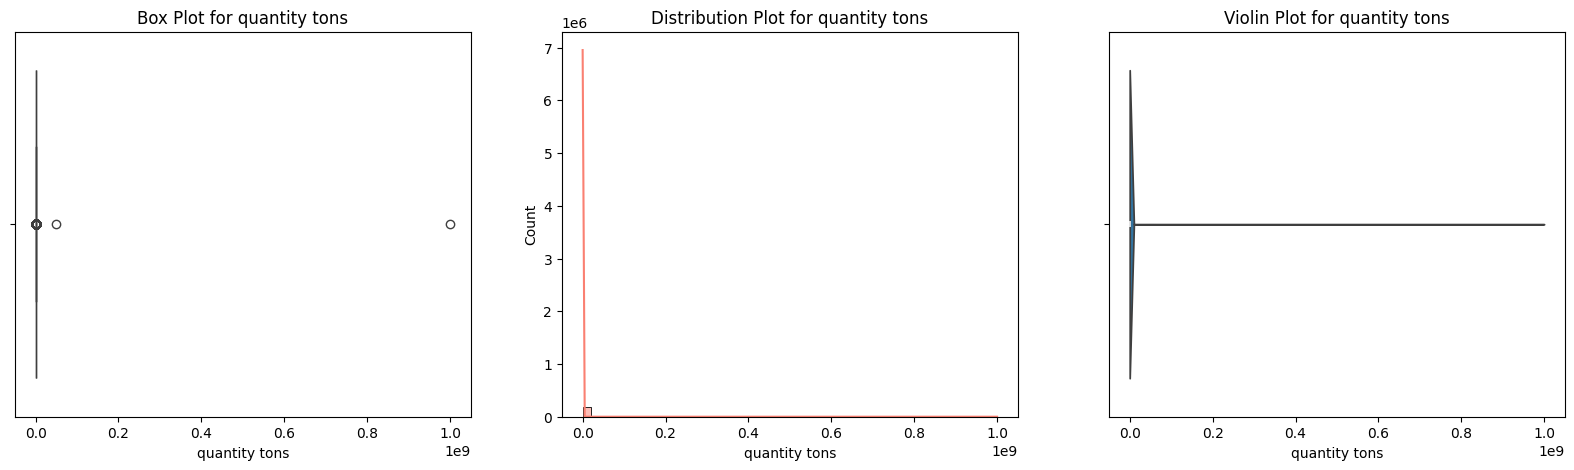

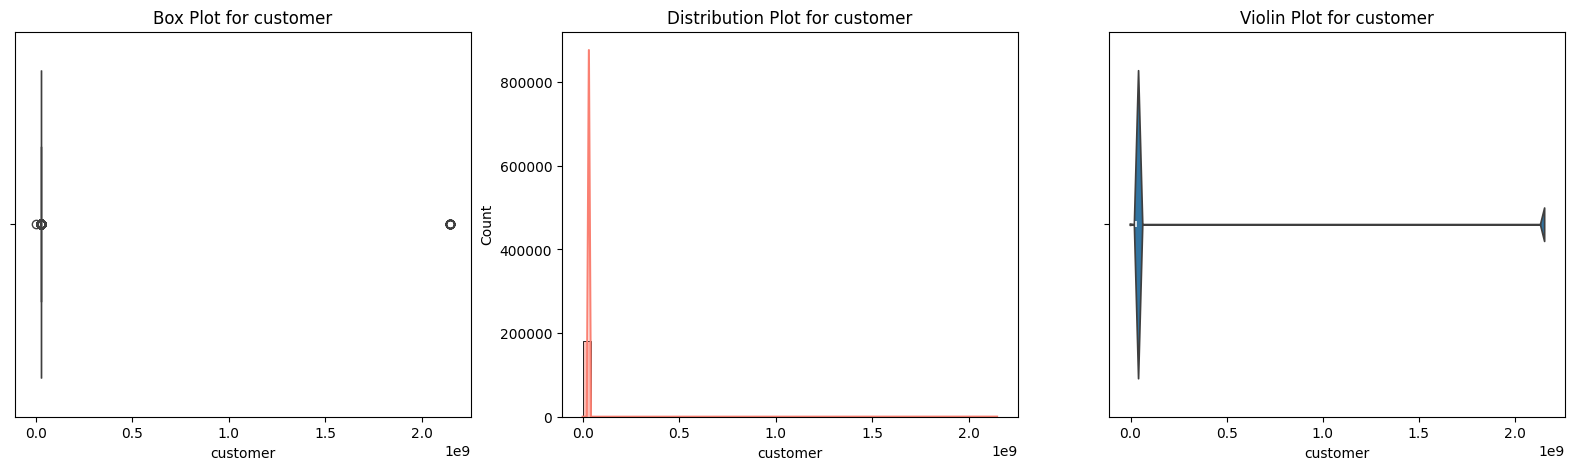

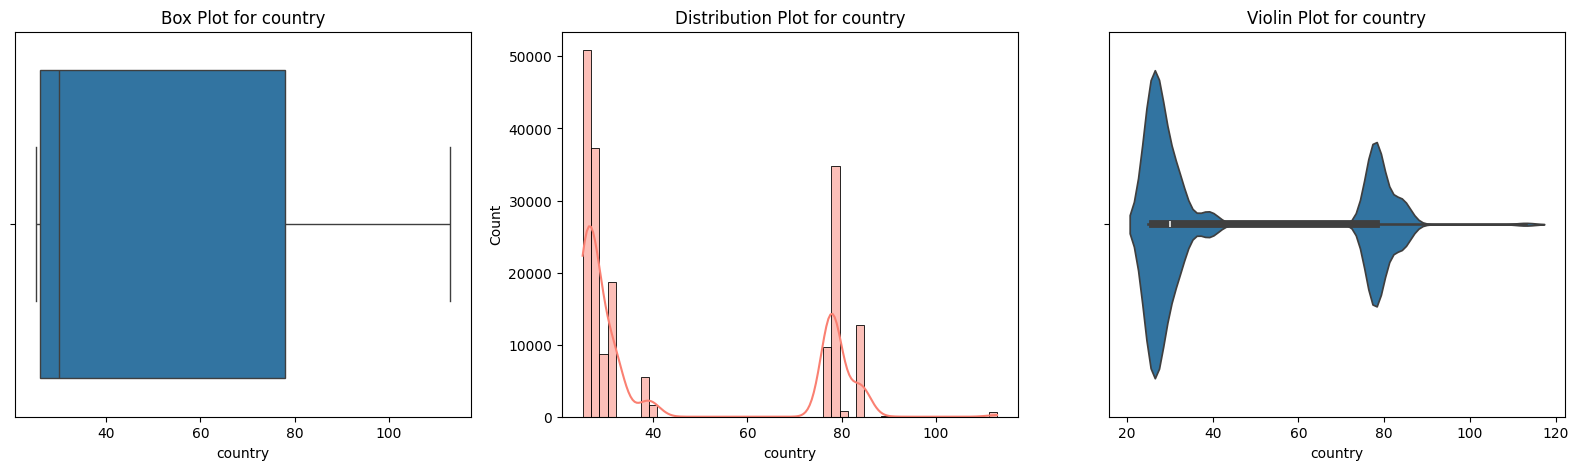

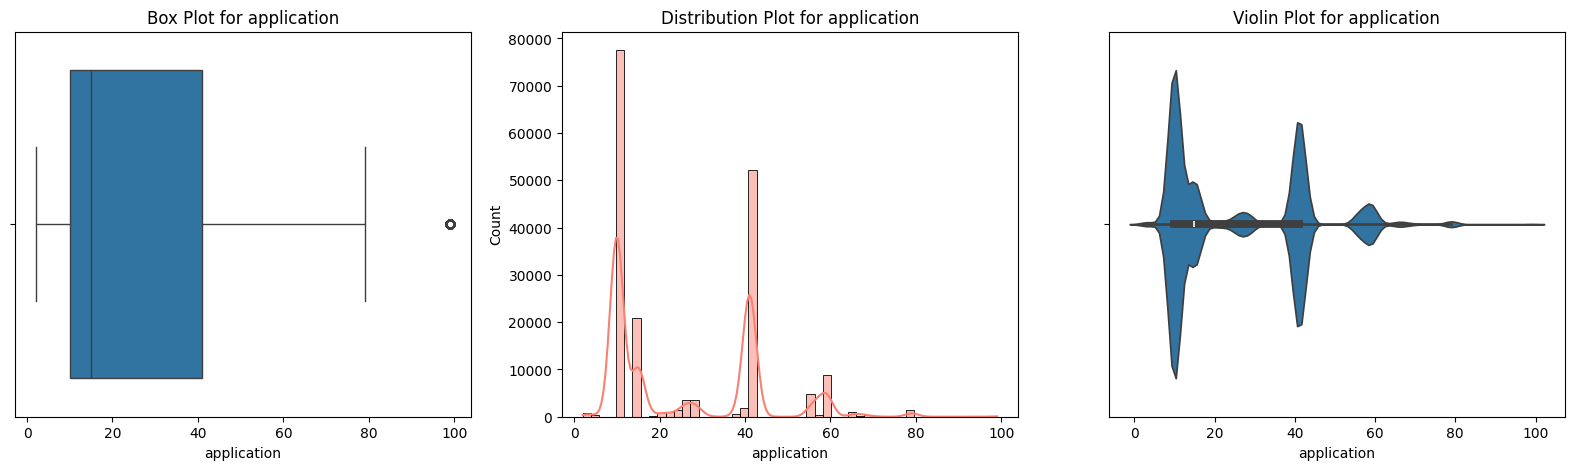

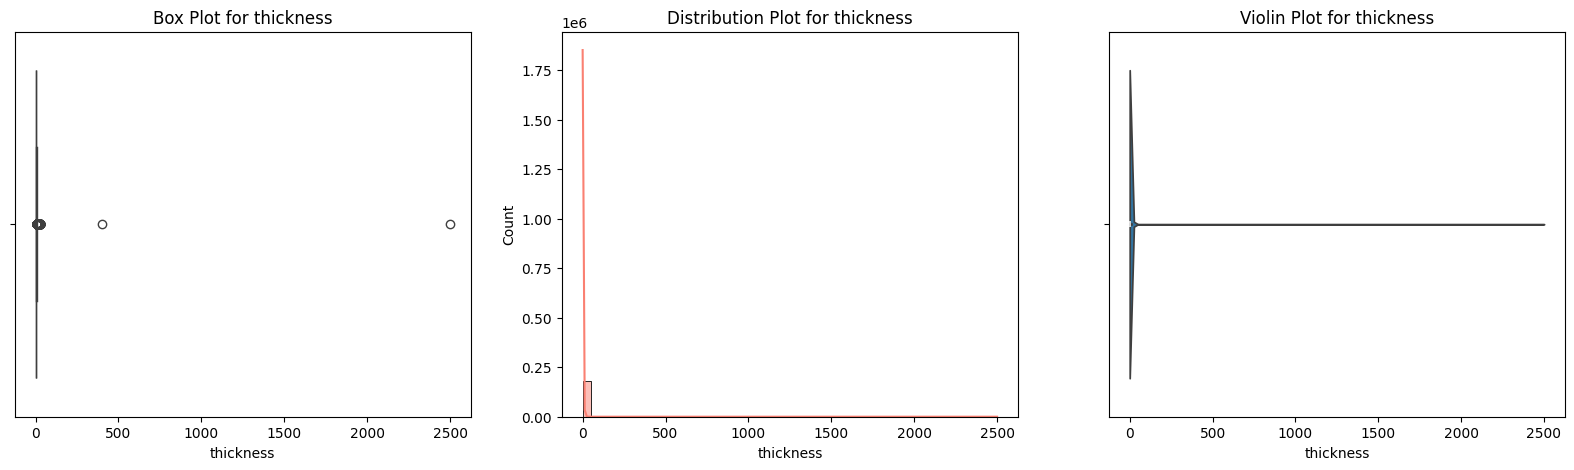

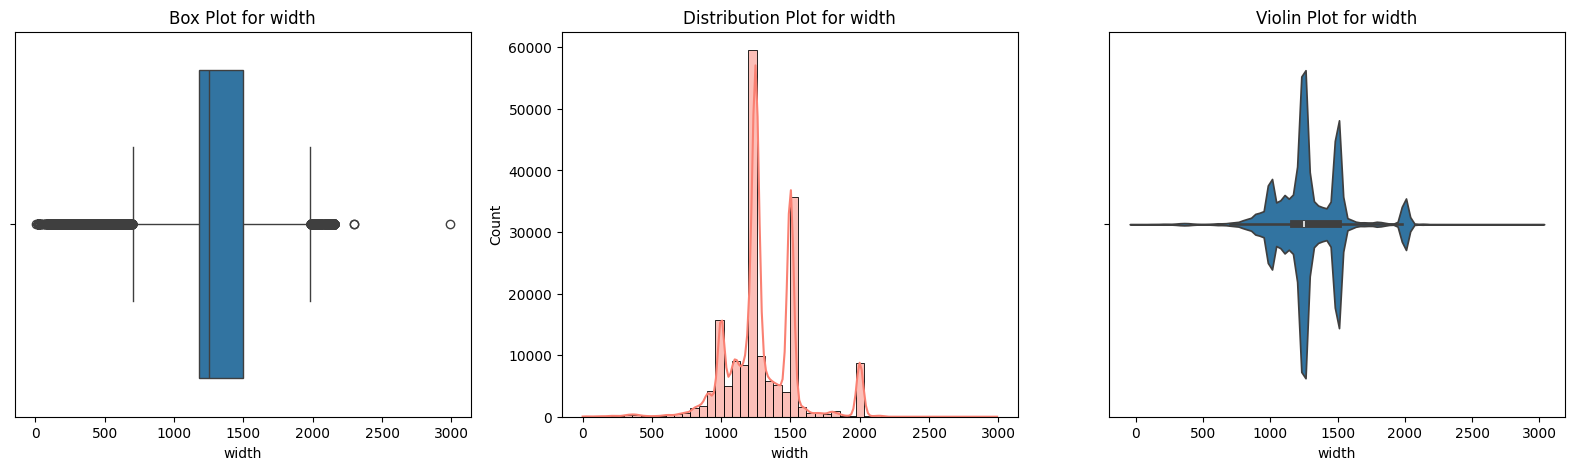

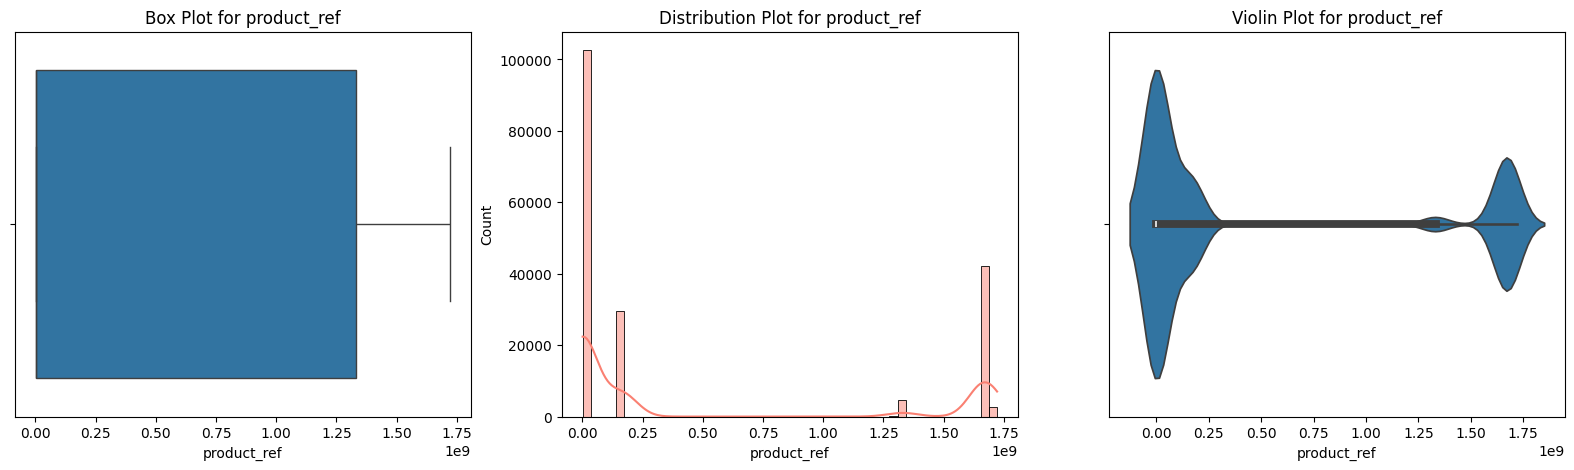

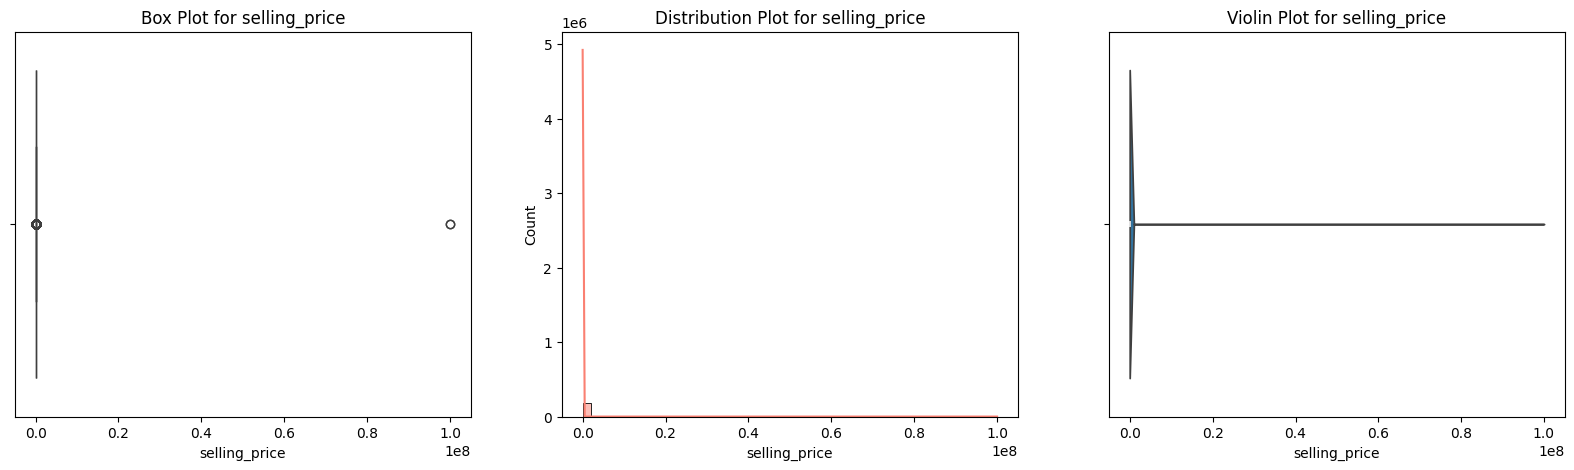

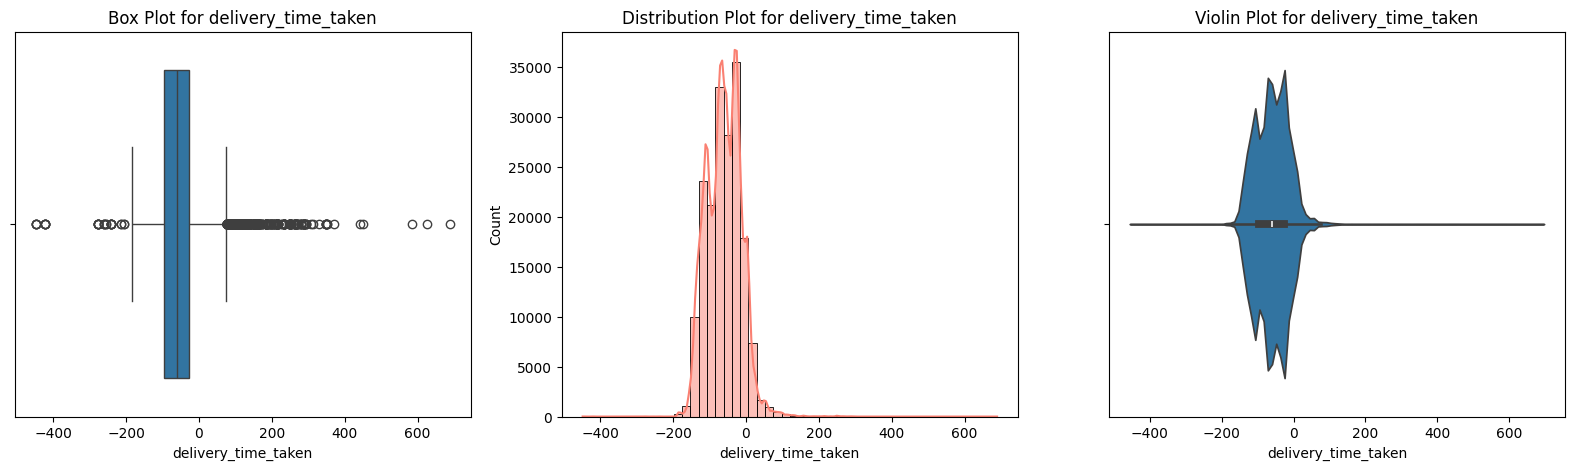

In [46]:
# plotting the features to check skew and outliers

for i in ['quantity tons', 'customer', 'country', 'application', 'thickness', 'width','product_ref', 'selling_price','delivery_time_taken']:
    plot(df_1, i)

In [25]:
# Handling Skew with Log Transformation Method - Reduce the skewness in the data

df_1['quantity_tons_log']=np.log(df_1['quantity tons'])
df_1['thickness_log']=np.log(df_1['thickness'])
df_1['selling_price_log']=np.log(df_1['selling_price'])
df_1.head()

,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,selling_price,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,1670798778,854.00,-91.0,3.991779,0.693147,6.749931
1,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,1668701718,1047.00,0.0,6.643822,-0.223144,6.953684
2,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,628377,644.33,90.0,5.956169,-0.967584,6.468211
3,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,1668701718,768.00,90.0,5.310301,0.832909,6.643790
4,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,640665,577.00,31.0,6.666354,1.386294,6.357842


In [26]:
df_1.drop(columns=['quantity tons','thickness','selling_price'], inplace=True)
df_1.head()

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,28.0,Won,W,10.0,1500.0,1670798778,-91.0,3.991779,0.693147,6.749931
1,30202938.0,25.0,Won,W,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30.0,Won,WI,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,32.0,Won,S,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,28.0,Won,W,10.0,2000.0,640665,31.0,6.666354,1.386294,6.357842


In [27]:
df_1.isnull().sum()

customer               0
country                0
status                 0
item type              0
application            0
width                  0
product_ref            0
delivery_time_taken    0
quantity_tons_log      0
thickness_log          0
selling_price_log      0
dtype: int64

In [28]:
# outliers handle with IQR(Interquartile Range) and cliping method 

def outlier(df, column):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    upper_threshold = df[column].quantile(0.75) + (1.5*iqr)
    lower_threshold = df[column].quantile(0.25) - (1.5*iqr)
    df[column] = df[column].clip(lower_threshold, upper_threshold)

In [29]:
# Using the outlier function to handle outliers in the specified columns

outlier(df_1,'quantity_tons_log')
outlier(df_1,'thickness_log')
outlier(df_1,'selling_price_log')
outlier(df_1,'width')
df_1

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,28.0,Won,W,10.0,1500.0,1670798778,-91.0,3.991779,0.693147,6.749931
1,30202938.0,25.0,Won,W,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30.0,Won,WI,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,32.0,Won,S,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,28.0,Won,W,10.0,1980.0,640665,31.0,6.666354,1.386294,6.357842
...,...,...,...,...,...,...,...,...,...,...,...
181668,30200854.0,25.0,Won,W,41.0,1220.0,164141591,1.0,4.629691,-0.040822,6.381816
181669,30200854.0,25.0,Won,W,41.0,1500.0,164141591,1.0,5.337954,-0.051293,6.378426
181670,30200854.0,25.0,Won,W,41.0,1250.0,164141591,1.0,1.443523,-0.342490,6.428105
181671,30200854.0,25.0,Won,W,41.0,1250.0,164141591,1.0,3.413291,-0.162519,6.398595


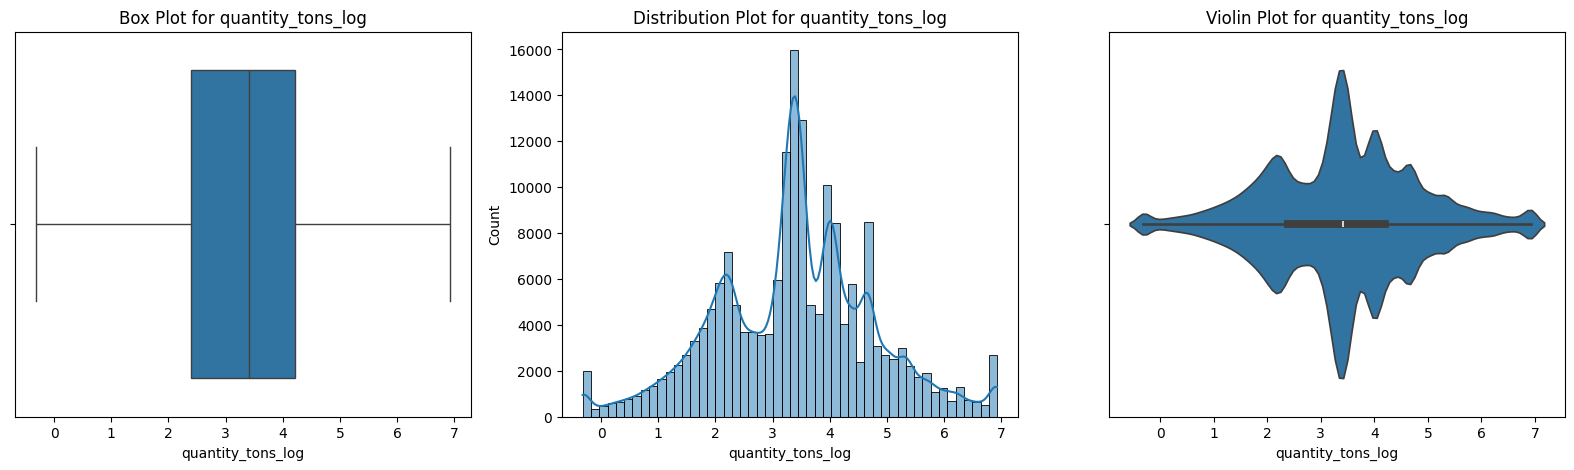

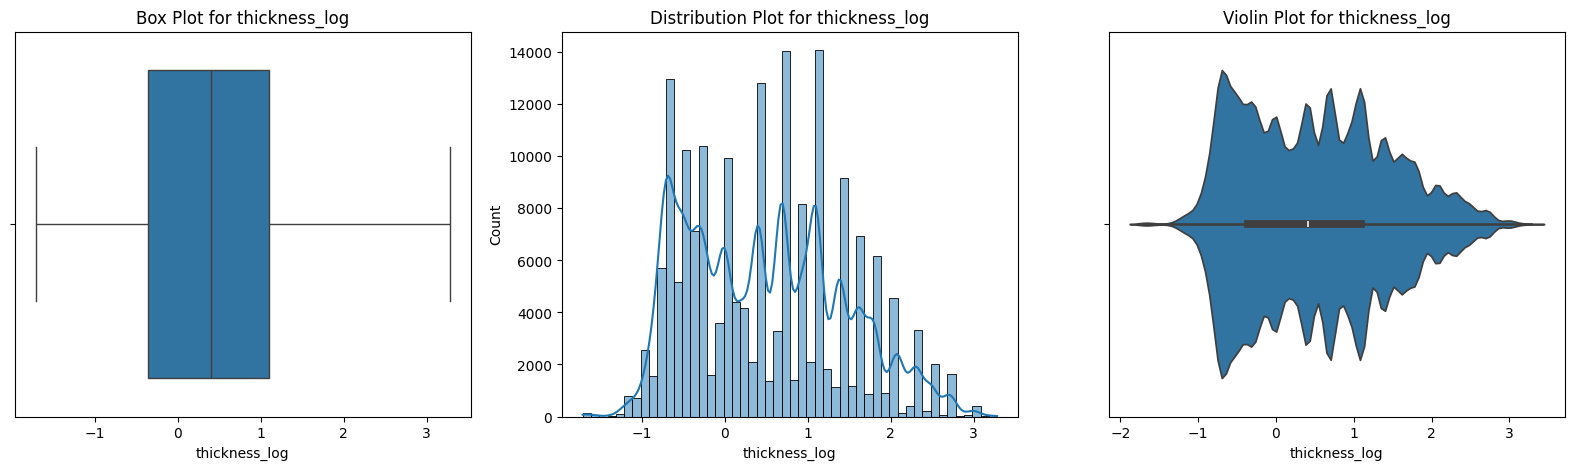

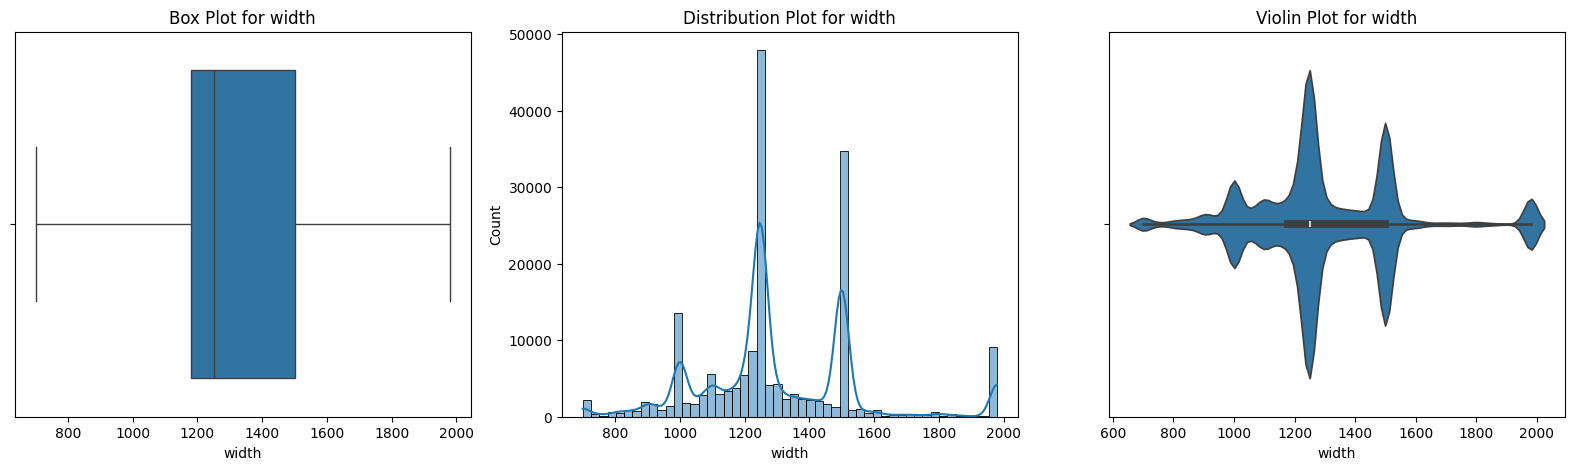

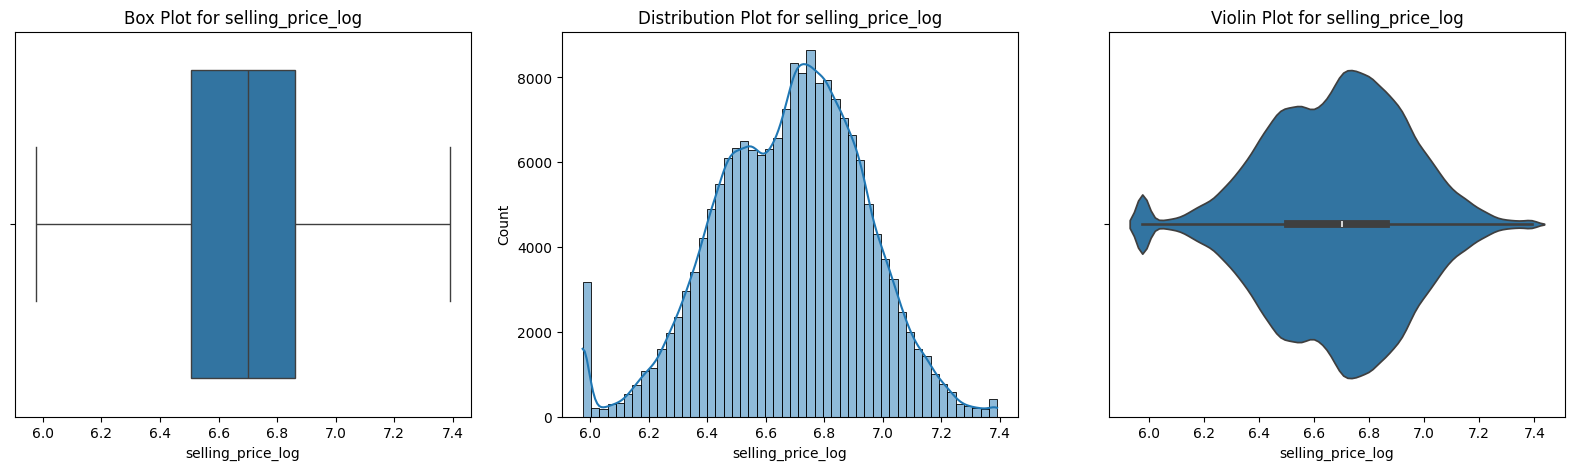

In [30]:
#plotting after skew and outliers  - (Box Plot, Distribution Plot, and Violin Plot)

for i in ['quantity_tons_log', 'thickness_log', 'width', 'selling_price_log']:
    plot(df_1, i)

#### Guidelines for interpreting skewness values:   <br>

Skewness value close to 0: The distribution is approximately symmetrical.<br>
Skewness value between -0.5 and -1 or between 0.5 and 1: The distribution is moderately skewed.<br>
Skewness value less than -1 or greater than 1: The distribution is highly skewed.<br>

### FEATURE ENGINEERING
- Lable encoding
- Feature selection
- Standardize / normalize data

<Axes: >

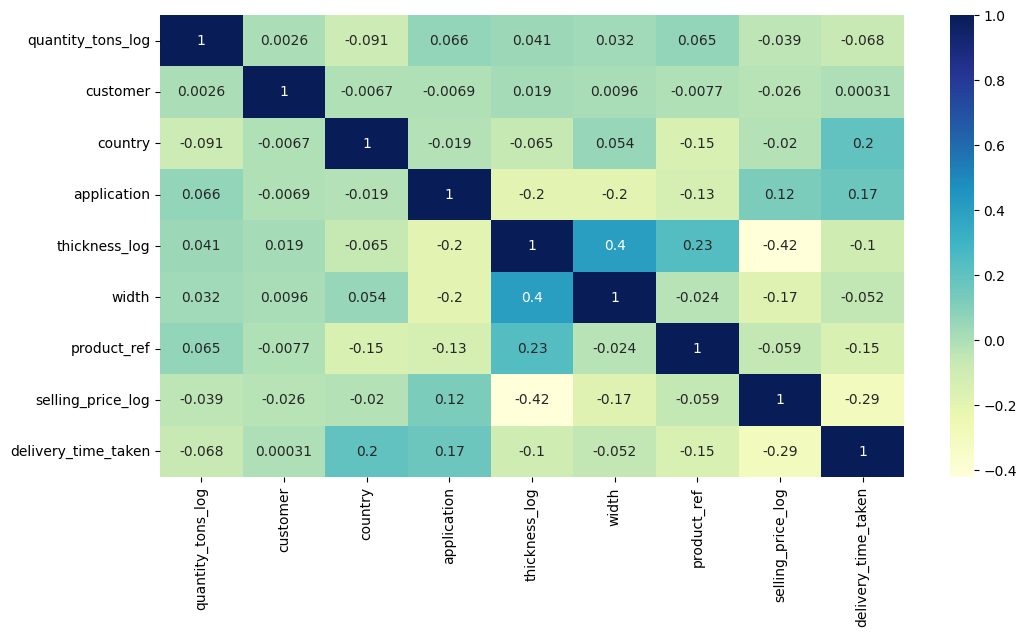

In [31]:
# Verify if any columns are highly correlated using a Heatmap
cor = df_1[['quantity_tons_log', 'customer', 'country', 'application', 'thickness_log', 'width', 'product_ref', 'selling_price_log', 'delivery_time_taken']].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(cor, annot=True, cmap='YlGnBu')


# Regression model - To predict selling price

In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn import metrics

import pickle

In [150]:
# copy the dataframe to another for regression model  (df_1 to df_2)
df_2=df_1.copy()
df_2

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,28.0,Won,W,10.0,1500.0,1670798778,-91.0,3.991779,0.693147,6.749931
1,30202938.0,25.0,Won,W,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30.0,Won,WI,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,32.0,Won,S,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,28.0,Won,W,10.0,1980.0,640665,31.0,6.666354,1.386294,6.357842
...,...,...,...,...,...,...,...,...,...,...,...
181668,30200854.0,25.0,Won,W,41.0,1220.0,164141591,1.0,4.629691,-0.040822,6.381816
181669,30200854.0,25.0,Won,W,41.0,1500.0,164141591,1.0,5.337954,-0.051293,6.378426
181670,30200854.0,25.0,Won,W,41.0,1250.0,164141591,1.0,1.443523,-0.342490,6.428105
181671,30200854.0,25.0,Won,W,41.0,1250.0,164141591,1.0,3.413291,-0.162519,6.398595


In [71]:
# Check for missing values in df_2
print("Missing values in df_2:")
print(df_2.isnull().sum())


Missing values in df_2:
customer               0
country                0
status                 0
item type              0
application            0
width                  0
product_ref            0
delivery_time_taken    0
quantity_tons_log      0
thickness_log          0
selling_price_log      0
dtype: int64


In [151]:
#checking values count to encoding the catogorical features

df_2["status"].value_counts()

status
Won                116012
Lost                34438
Not lost for AM     19573
Revised              4276
To be approved       4170
Draft                3140
Offered                53
Offerable              10
Wonderful               1
Name: count, dtype: int64

In [73]:
# using map function encoding the values in status column

df_2["status"]= df_2["status"].map({'Won':1, 'Draft':2, 'To be approved':3, 'Lost':0, 'Not lost for AM':4,
                                'Wonderful':5, 'Revised':6, 'Offered':7, 'Offerable':8})
df_2['status'].unique()

array([1, 2, 3, 0, 4, 5, 6, 7, 8], dtype=int64)

In [74]:
#checking values count to encoding the catogorical features

df_2['item type'].value_counts()

item type
W         105615
S          69236
PL          5660
Others       610
WI           524
IPL           27
SLAWR          1
Name: count, dtype: int64

In [152]:
# using map function encoding the values in status column

df_2["status"]= df_2["status"].map({'Won':1, 'Draft':2, 'To be approved':3, 'Lost':0, 'Not lost for AM':4,
                                'Wonderful':5, 'Revised':6, 'Offered':7, 'Offerable':8})
df_2['status'].unique()

array([1, 2, 3, 0, 4, 5, 6, 7, 8], dtype=int64)

In [154]:
#checking values count to encoding the catogorical features

df_2['item type'].value_counts()

item type
W         105615
S          69236
PL          5660
Others       610
WI           524
IPL           27
SLAWR          1
Name: count, dtype: int64

In [155]:
# using ordinalencoder to encode the values in item type column

df_2["item type"]= OrdinalEncoder().fit_transform(df_2[["item type"]])
df_2['item type'].unique()

array([5., 6., 3., 1., 2., 0., 4.])

In [156]:
df_2.head()

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,28.0,1,5.0,10.0,1500.0,1670798778,-91.0,3.991779,0.693147,6.749931
1,30202938.0,25.0,1,5.0,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30.0,1,6.0,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,32.0,1,3.0,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,28.0,1,5.0,10.0,1980.0,640665,31.0,6.666354,1.386294,6.357842


In [157]:
# function to choose the best algorithm

def best_ML_algorithm(df,algorithms):
        x=df.drop(columns=['selling_price_log'],axis=1)
        y=df['selling_price_log']

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

        results={}

        for algorithm in algorithms:

                model=algorithm().fit(x_train,y_train)
                y_pred=model.predict(x_test)
                
                MAE=metrics.mean_absolute_error(y_test, y_pred)
                MSE=metrics.mean_squared_error(y_test, y_pred)
                RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
                r2 = metrics.r2_score(y_test, y_pred)

                results[algorithm.__name__] = {'Mean Absolute Error':MAE,'Mean Squared Error':MSE,'Root Mean Squared Error':RMSE,
                                        'R² score':r2}
                
        best_algorithm = max(results.items(), key=lambda item: item[1]['R² score'])[0]  
        
        return best_algorithm, results        

In [158]:
# using above function try to identify the best algorithm

algorithms = [LinearRegression, DecisionTreeRegressor, ExtraTreesRegressor, RandomForestRegressor,
            GradientBoostingRegressor, XGBRegressor]
best_algorithm, results = best_ML_algorithm(df_2, algorithms)

results_df = pd.DataFrame(results).transpose()

print("**Evaluation Metrics for All Algorithms:**")
print(results_df.to_string())

print("**Best Algorithm:**",best_algorithm)


**Evaluation Metrics for All Algorithms:**
                           Mean Absolute Error  Mean Squared Error  Root Mean Squared Error  R² score
LinearRegression                      0.162783            0.045199                 0.212601  0.307088
DecisionTreeRegressor                 0.051790            0.009282                 0.096342  0.857709
ExtraTreesRegressor                   0.045123            0.005410                 0.073553  0.917064
RandomForestRegressor                 0.044473            0.005205                 0.072146  0.920206
GradientBoostingRegressor             0.116287            0.020872                 0.144473  0.680024
XGBRegressor                          0.076017            0.010339                 0.101683  0.841495
**Best Algorithm:** RandomForestRegressor


In [ ]:
#-----

In [159]:
# hyper parameter tuning to identify the best parameter using gridsearch cv

x=df_2.drop(columns=['selling_price_log'],axis=1)
y=df_2['selling_price_log']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

param_grid = { 
    'n_estimators' :[100,150],
    'max_depth': [10,20],     
    'min_samples_split': [2,4], 
    'min_samples_leaf': [1,2],
    'max_features'    : ['sqrt', 'log2', None] }


grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                            param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train)

grid_search.best_params_,grid_search.best_score_

({'max_depth': 20,
  'max_features': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 150},
 0.901629912958735)

In [160]:
# with best algorithm matching the parameter from above result and train the model

x=df_2.drop(columns=['selling_price_log'],axis=1)
y=df_2['selling_price_log']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

model_regressor = RandomForestRegressor(n_estimators=150,max_features=None,max_depth=20,min_samples_leaf=1,min_samples_split=2,random_state=42)
model_regressor.fit(x_train, y_train)

y_pred = model_regressor.predict(x_test)

# evaluation metrics 
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = metrics.r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {MAE}")
print(f"Mean Squared Error: {MSE}")
print(f"Root Mean Squared Error: {RMSE}")
print(f"R-squared: {r2}")

Mean Absolute Error: 0.04669534364251843
Mean Squared Error: 0.0054281616326437845
Root Mean Squared Error: 0.07367605874803418
R-squared: 0.9167853277466811


In [161]:
#checkig the features scores and importants

feature_scores = pd.Series(model_regressor.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_scores

product_ref            0.295377
delivery_time_taken    0.254379
status                 0.169992
country                0.072213
customer               0.065385
thickness_log          0.043334
quantity_tons_log      0.040100
application            0.022660
item type              0.019041
width                  0.017519
dtype: float64

In [162]:
# store the model using pickle

with open('Regressor.pkl','wb') as files:
    pickle.dump(model_regressor,files)

In [163]:
#load the pickle and predict the selling price with regressor model

with open('Regressor.pkl','rb') as files:
    predict_model=pickle.load(files)

pre=predict_model.predict(np.array([[30156308.0,28.0,1,5.0,10.0,1500.0,1670798778,91.0,3.991779,0.693147]]))
np.exp(pre[0])

568.6323214300073

# Classifier Model to predict the Status

In [111]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc

In [112]:
#filter out the values (won|lost) in status column

df_3=df_2[(df_2.status==1)|(df_2.status==0)]
df_3

,customer,country,status,item type,application,width,product_ref,delivery_time_taken,quantity_tons_log,thickness_log,selling_price_log
0,30156308.0,28.0,1,5.0,10.0,1500.0,1670798778,-91.0,3.991779,0.693147,6.749931
1,30202938.0,25.0,1,5.0,41.0,1210.0,1668701718,0.0,6.643822,-0.223144,6.953684
2,30153963.0,30.0,1,6.0,28.0,952.0,628377,90.0,5.956169,-0.967584,6.468211
3,30349574.0,32.0,1,3.0,59.0,1317.0,1668701718,90.0,5.310301,0.832909,6.643790
4,30211560.0,28.0,1,5.0,10.0,1980.0,640665,31.0,6.666354,1.386294,6.357842
...,...,...,...,...,...,...,...,...,...,...,...
181668,30200854.0,25.0,1,5.0,41.0,1220.0,164141591,1.0,4.629691,-0.040822,6.381816
181669,30200854.0,25.0,1,5.0,41.0,1500.0,164141591,1.0,5.337954,-0.051293,6.378426
181670,30200854.0,25.0,1,5.0,41.0,1250.0,164141591,1.0,1.443523,-0.342490,6.428105
181671,30200854.0,25.0,1,5.0,41.0,1250.0,164141591,1.0,3.413291,-0.162519,6.398595


In [113]:
#checking balance of the status values

df_3['status'].value_counts()

status
1    116012
0     34438
Name: count, dtype: int64

In [131]:
#function to get the best classifier algorithm
def best_ML_class_algo(x_smote,y_smote,algorithms):
        
        x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=42)

        results={}

        for algorithm in algorithms:

                model=algorithm().fit(x_train,y_train)
                y_pred=model.predict(x_test)

                accuracy =metrics. accuracy_score(y_test, y_pred)
                precision =metrics. precision_score(y_test, y_pred)
                recall =metrics. recall_score(y_test, y_pred)
                f1 = metrics.f1_score(y_test, y_pred)

                results[algorithm.__name__] = {'Accuracy score': accuracy,'Precision': precision,'Recall': recall,'F1-score': f1}
                
        best_algorithm = max(results.items(), key=lambda item: item[1]['Accuracy score'])[0]  
        
        return best_algorithm, results  

In [132]:
# using above function try to identify the best algorithm

algorithms = [ DecisionTreeClassifier, ExtraTreesClassifier, RandomForestClassifier,
            GradientBoostingClassifier, XGBClassifier]
best_algorithm, results = best_ML_class_algo(x_smote,y_smote, algorithms)

results_df = pd.DataFrame(results).transpose()

print("**Evaluation Metrics for All Algorithms:**")
print(results_df.to_string())

print("**Best Algorithm:**",best_algorithm)

**Evaluation Metrics for All Algorithms:**
                            Accuracy score  Precision    Recall  F1-score
DecisionTreeClassifier            0.955292   0.955747  0.954255  0.955000
ExtraTreesClassifier              0.977689   0.987608  0.967259  0.977327
RandomForestClassifier            0.976023   0.985667  0.965814  0.975640
GradientBoostingClassifier        0.805971   0.822230  0.777893  0.799448
XGBClassifier                     0.935553   0.951600  0.917006  0.933983
**Best Algorithm:** ExtraTreesClassifier


In [133]:
# hyper parameter tuning to identify the best parameter using gridsearch cv

x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators' :[50,100],
    'max_depth': [ 10,20,25],     
    'min_samples_split': [2, 4],  
    'min_samples_leaf': [1, 2]     }


model = ExtraTreesClassifier(random_state=42) 

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="accuracy",n_jobs=-1)

grid_search.fit(x_train, y_train)

grid_search.best_params_,grid_search.best_score_

({'max_depth': 25,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 0.9612661281496365)

In [134]:
# with best algorithm matching the parameter from bove result and train the model

x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=42)

model_classifier = ExtraTreesClassifier(n_estimators=100,max_depth=25,min_samples_leaf=1,min_samples_split=2)
model_classifier.fit(x_train, y_train)

y_pred = model_classifier.predict(x_test)

# evaluation metrics
print(metrics.confusion_matrix(y_test,y_pred))
print(metrics.classification_report(y_test,y_pred))

[[34634   369]
 [ 2067 32538]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     35003
           1       0.99      0.94      0.96     34605

    accuracy                           0.97     69608
   macro avg       0.97      0.96      0.96     69608
weighted avg       0.97      0.97      0.96     69608



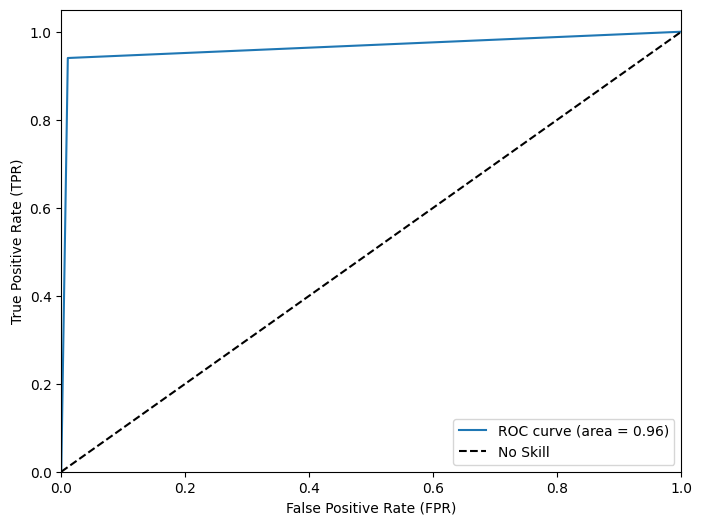

In [135]:
# Receiver Operating Characteristic (ROC) Curve and Area Under the Curve (AUC)

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
auc_curve=auc(x=fpr,y=tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_curve)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="lower right")
plt.show()

In [136]:
#checkig the features scores and importants

feature_scores = pd.Series(model_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_scores

delivery_time_taken    0.171874
item type              0.134305
customer               0.125403
country                0.118530
application            0.112199
quantity_tons_log      0.091815
selling_price_log      0.075881
product_ref            0.063850
thickness_log          0.062910
width                  0.043231
dtype: float64

In [137]:
# store the model using pickle

with open('Classifier.pkl','wb') as  files:
    pickle.dump(model_classifier,files)

In [138]:
# load the pickle and predict the status with classifier model

with open('Classifier.pkl','rb') as files:
    clas_model=pickle.load(files)

cla = clas_model.predict( np.array([[30156308.0,28.0,5.0,10.0,1500.0,1670798778,91.0,3.991779,0.693147,6.749931]]))
if cla[0] == 1:
    print('Won')
else:
    print('Lose')

Won


In [195]:
import pandas as pd

data = {
    "Data": [
        "id",
        "item_date",
        "quantity tons",
        "customer",
        "country",
        "status",
        "item type",
        "application",
        "thickness",
        "width",
        "material_ref",
        "product_ref",
        "delivery date",
        "selling_price"
    ],
    "Define": [
        "Unique identifier for tracking transactions or items.",
        "Date of transaction or item recording.",
        "Quantity of item in tons.",
        "Name or identifier of customer.",
        "Country associated with customer.",
        "Current status of transaction or item.",
        "Category of items.",
        "Specific use or application of items.",
        "Details about thickness of items.",
        "Width of items.",
        "Reference for material used in items.",
        "Reference for specific product.",
        "Expected or actual delivery date for items.",
        "Price at which items are sold."
    ],
    "Range": [
        "(min:10000)",
        "(DD/MM/YYYY)",
        "(0.1,max_value)",
        "(10000, max_value)",
        "NA",
        "NA",
        "NA",
        "NA",
        "(0.18, 400.0)",
        "(1.0, 2990.0)",
        "(0, max_value)",
        "(0, max_value)",
        "(DD/MM/YYYY)",
        "(0.1, 100001015))"
    ]
}

df_list = pd.DataFrame(data)



In [196]:
df_list

,Data,Define,Range
0,id,Unique identifier for tracking transactions or...,(min:10000)
1,item_date,Date of transaction or item recording.,(DD/MM/YYYY)
2,quantity tons,Quantity of item in tons.,"(0.1,max_value)"
3,customer,Name or identifier of customer.,"(10000, max_value)"
4,country,Country associated with customer.,NA
5,status,Current status of transaction or item.,NA
6,item type,Category of items.,NA
7,application,Specific use or application of items.,NA
8,thickness,Details about thickness of items.,"(0.18, 400.0)"
9,width,Width of items.,"(1.0, 2990.0)"


In [197]:
df_list.to_csv('data_description.csv', index=False)

In [194]:
df.to_csv('df_coppernew.csv',index=False)